## 0. R API Training - Introductory Notebook

<b>Author:</b> Thodoris Petropoulos and Chester Ismay<br>
<b>Contributors:</b> Rajiv Shah
 
Welcome to the `R API Training for DataRobot` course! This notebook provides you with the basics of how to connect to DataRobot, create a project, and execute simple but useful commands. Pay close attention as after you have finished reading this, there will be a series of exercises that you will have to complete in order to get certified! Of course, we do not expect you to know the DataRobot package by heart. You have three main documentation sources you can consult:

- [API Documentation via CRAN Vignettes](https://CRAN.R-project.org/package=datarobot)
- [Samples](https://github.com/datarobot-community/examples-for-data-scientists)
- [Tutorials](https://github.com/datarobot-community/tutorials-for-data-scientists)

The last two links should provide you with the snippets you need to complete most of these exercises.

Here is a high level overview of this notebook: 

1. Connecting to DataRobot <br>
2. Creating a Project <br>
3. Creating a Project with custom settings <br>
4. Extracting Insights <br>
5. Model Deployment<br>

<b>Data</b>

The dataset we will be using throughout these exercises is the well-known `readmissions` dataset. You can access it or directly download it through DataRobot's public S3 bucket [here](https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv).

<b>Requirements</b>

- R version 3.6.1
- DataRobot API version 2.17.1

Small adjustments might be needed depending on the R version and DataRobot API version you are using.

### Import Libraries

In [1]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### 1. Connecting to DataRobot
To use R with DataRobot you first need to establish a connection between your machine and the DataRobot instance. The fastest and safest way to do that is by creating a `.yaml` file with your credentials. This is basically a text file containing two lines:

`endpoint: "YOUR_HOSTNAME"` <br>
`token: "YOUR_API_TOKEN"`

You can then use the `ConnectToDataRobot()` function in the `datarobot` package to connect to DataRobot like below. If you choose not to use a yaml file, this is an example of the command you would use to connect to DataRobot's managed cloud service. (An on-premise customer would have a different endpoint location).

`ConnectToDataRobot(endpoint = 'https://app.datarobot.com/api/v2', token = 'YOUR_API_TOKEN')`

In [4]:
datarobot::ConnectToDataRobot(configPath = 'config.yaml')
library(datarobot)

Authentication token saved
Authenticating with config at: /Users/chester.ismay/.config/datarobot/drconfig.yaml
Authentication token saved


### 2. Creating a Project
For Classification, Regression and Multiclass Classification, the process of starting a project (and modeling) is very straightforward. All you have to do is use the `StartProject()` function.

Of course, there are many advanced options that we could have customised but we are going to touch on that later in this script. For now, we are going to use the default settings.

In [ ]:
#I can link directly to my data (file, url) or I can also pass a dataframe to the dataSource variable
url_to_data <- "https://s3.amazonaws.com/datarobot_public_datasets/10k_diabetes.csv" 

project <- StartProject(dataSource = url_to_data,
                        projectName = '00_Introduction',
                        target = 'readmitted',
                        workerCount = -1)

WaitForAutopilot(project = project)

The `WaitForAutopilot()` function will force our R Kernel to wait until DataRobot has finished modeling before executing the next series of commands.

The `workerCount` variable defines how many workers is the project going to use when modeling. The value -1 means use all of the available workers.

### 3. Creating a Project with custom settings

We are now going to be using the same data to create a project with custom settings.More specifically: 

- Start the project with `3-fold` cross validation
- Start the project with `AUC` as the optimisation metric

To change the optimisation metric, we can just put a custom value in the `metric` variable. When it comes to partitioning, we need to define a partition object using the datarobot package. Some of the available partitioning functions that will create the partition object are:

- `CreateStratifiedPartition()`
- `CreateRandomPartition()`
- `CreateGroupPartition()`
- `CreateUserPartition()`

In [17]:
partitioning <- CreateStratifiedPartition(validationType = "CV",
                                          holdoutPct = 20, 
                                          reps = 3)

c_project <- StartProject(dataSource = url_to_data,
                          projectName = '00_Introduction_with_custom_settings',
                          target = 'readmitted',
                          metric = 'AUC',
                          workerCount = 1,
                          partition = partitioning)

Project 00_Introduction_with_custom_settings creation requested, awaiting creation
Project 5f20573f60481d069ca8515c (00_Introduction_with_custom_settings) created
Autopilot started
Project 5f20573f60481d069ca8515c updated


### 4. Extracting Insights
There are multiple insights that we would want to extract from a finished project in DataRobot:

1. Trained models <br>
2. Feature Impact<br>
3. ROC Curve<br>

#### Get Trained Models
We can use the `ListModels()` function to retrieve a list of all the trained DataRobot models for a specified `project`. We can then choose the model we want from the list and get access to multiple methods for results/specifics.

By default, the models will be ordered based on their validation score. The first model will be the most accurate one.

In [ ]:
ListModels(project)[1:3]

In [15]:
#Get most accurate model
most_accurate_model <- ListModels(project)[[1]]

#Get type of model
print(most_accurate_model$modelType)

[1] "AVG Blender"

#### Get Feature Impact

Using the `GetFeatureImpact()` method, we will be retrieving feature impact, save it into a dataframe, and then plot it.

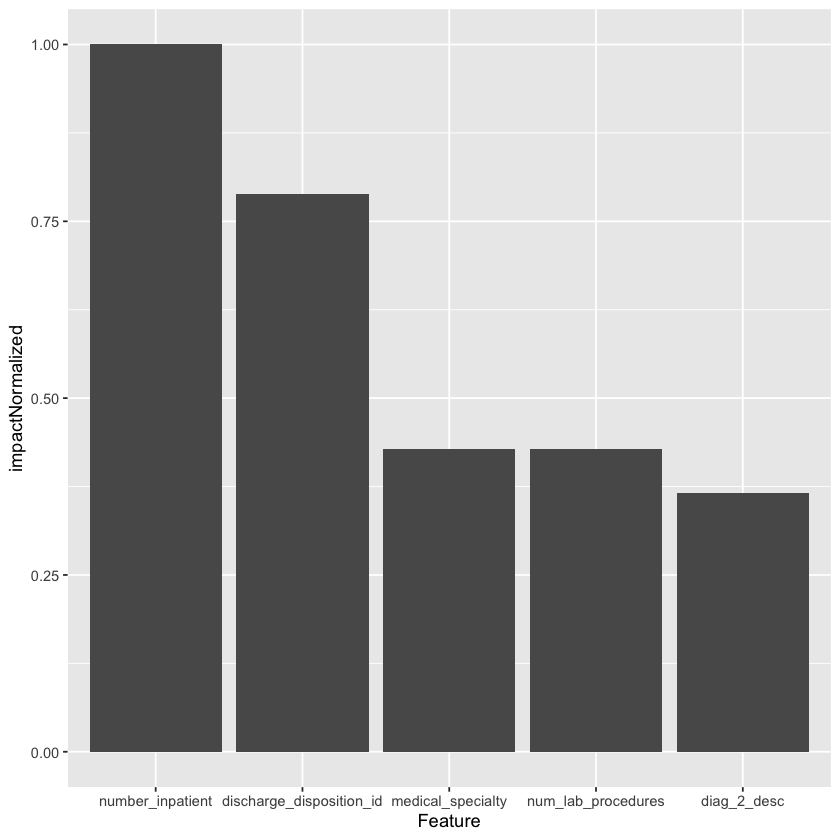

In [33]:
#Get Feature Impact as a dataframe
fi_df <- GetFeatureImpact(most_accurate_model)

# Create plot of top 5 features based on Feature Impact
ggplot(data = fi_df %>% slice(1:5),
       mapping = aes(
           x = reorder(featureName, -impactNormalized), 
           y = impactNormalized)) + 
    geom_col() +
    labs(x = "Feature")

#### Get ROC Curve

ROC curve data can be generated for a specific data partition (validation, cross validation, or holdout) or for all the data partitions. Use the <code>get_roc_curve</code> method combined with the partitioning of your choice. You can then plot the data like below.

In [25]:
roc <- GetRocCurve(model = most_accurate_model,
                   source = 'validation')
roc_df <- roc$rocPoints
head(roc_df)

fractionPredictedAsPositive,falseNegativeScore,falsePositiveRate,trueNegativeScore,truePositiveScore,matthewsCorrelationCoefficient,liftNegative,trueNegativeRate,fractionPredictedAsNegative,threshold,liftPositive,positivePredictiveValue,negativePredictiveValue,falsePositiveScore,truePositiveRate,f1Score,accuracy
0.00000,635,0.000000000,965,0,0.00000000,1.000000,1.0000000,1.00000,1.0000000,0.000000,0.0000,0.6031250,0,0.000000000,0.000000000,0.603125
0.00125,633,0.000000000,965,2,0.04361174,1.001252,1.0000000,0.99875,0.9218600,2.519685,1.0000,0.6038798,0,0.003149606,0.006279435,0.604375
0.00375,629,0.000000000,965,6,0.07563247,1.003764,1.0000000,0.99625,0.8826312,2.519685,1.0000,0.6053952,0,0.009448819,0.018720749,0.606875
0.00625,625,0.000000000,965,10,0.09776384,1.006289,1.0000000,0.99375,0.8387990,2.519685,1.0000,0.6069182,0,0.015748031,0.031007752,0.609375
0.01000,620,0.001036269,964,15,0.11105753,1.009054,0.9989637,0.99000,0.8017493,2.362205,0.9375,0.6085859,1,0.023622047,0.046082949,0.611875
0.01250,618,0.003108808,962,17,0.10420149,1.009510,0.9968912,0.98750,0.7886716,2.141732,0.8500,0.6088608,3,0.026771654,0.051908397,0.611875


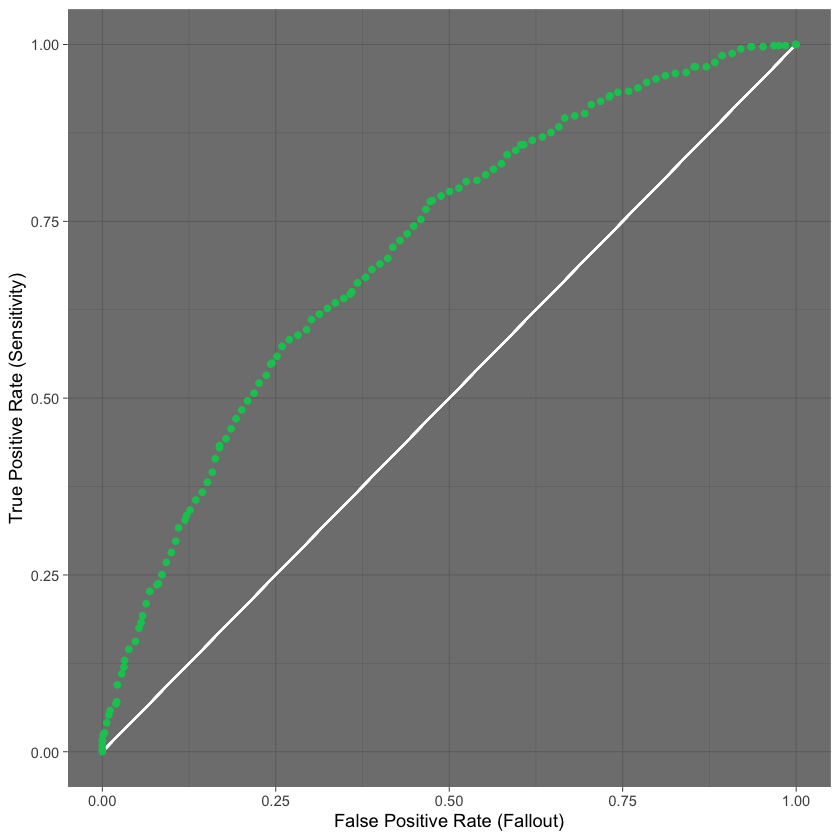

In [32]:
dr_roc_green <- '#03c75f'
ggplot(data = roc_df,
       mapping = aes(x = falsePositiveRate,
                     y = truePositiveRate)) +
    geom_segment(mapping = aes(x = 0, xend = 1, y = 0, yend = 1), color = "white") +
    geom_point(color = dr_roc_green) +
    xlab("False Positive Rate (Fallout)") + 
    ylab("True Positive Rate (Sensitivity)") + 
    theme_dark()

### Model Deployment
If you wish to deploy a model, all you have to do is use the `CreateDeployment()` function. You also need to have the prediction server that you want to host this deployment. Available prediction servers can be retrieved using the `ListPredictionServers()` function.

In [ ]:
prediction_server <- ListPredictionServers()[[1]]

deployment <- CreateDeployment(model = most_accurate_model, 
                               label = 'New Deployment', 
                               description = 'A new deployment',
                               defaultPredictionServerId = prediction_server$id)
deployment